In [29]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# from sklearnex import patch_sklearn
# patch_sklearn()

In [31]:
import time

import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from src.utils import OffsetScaler, get_fps_offset
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import seaborn as sns


mae = 'neg_mean_absolute_error'
mse = 'neg_mean_squared_error'
rmse = 'neg_root_mean_squared_error'
roc_auc = 'neg_roc_auc_score'
N_JOBS = 12
RANDOM_SEED = 42

# prepare models
models = {}

models['LR'] = LogisticRegression()
models['Ridge'] = RidgeClassifier()
models['DT'] = DecisionTreeClassifier(random_state=RANDOM_SEED)
# models['Lasso'] = Lass()
models['KNN'] = KNeighborsClassifier(n_jobs=N_JOBS)
models['SVC'] = SVC()
models['RF'] = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=N_JOBS)
models['XGB'] = xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=N_JOBS, verbosity=0)
models['CB'] = cb.CatBoostClassifier(random_seed=RANDOM_SEED, thread_count=N_JOBS, verbose=False)
models['LGB'] = lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=N_JOBS, verbose=0)

In [32]:
X_train = pd.read_csv('../data/processed/X_train_1.csv.zip', index_col=0)
y_train = pd.read_csv('../data/processed/y_train_1.csv', index_col=0)

In [17]:
FPS_OFFSET = get_fps_offset(X_train.columns)
scaler = OffsetScaler(offset=FPS_OFFSET)
X_train_scale = scaler.fit_transform(X_train.values)

In [18]:
cv_res = cross_val_score(models['KNN'], X_train_scale, y_train, cv=5, scoring='roc_auc')
cv_res

array([0.85851721, 0.82930283, 0.85583667, 0.84618906, 0.86962774])

/home/ergot/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ergot/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

   LR: 0.862 ± 0.006    10.1s
Ridge: 0.787 ± 0.009    8.0s
   DT: 0.752 ± 0.018    26.4s
  KNN: 0.851 ± 0.009    1.0s
  SVC: 0.887 ± 0.012    100.7s
   RF: 0.899 ± 0.009    3.7s
  XGB: 0.901 ± 0.008    25.5s
   CB: 0.900 ± 0.011    229.6s
  LGB: 0.903 ± 0.011    15.8s


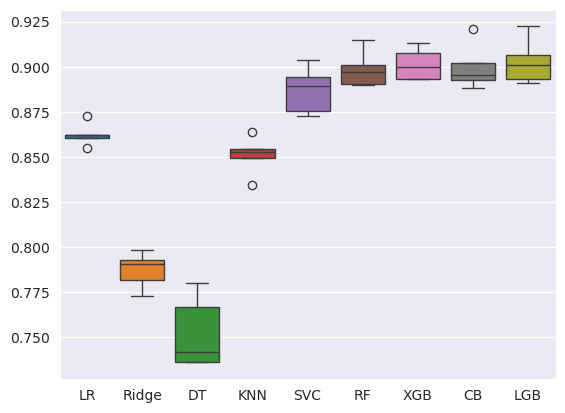

In [19]:
results = {}

for name in models.keys():
    tic = time.time()
    
    model = models[name]
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    results[name] = cross_val_score(model, X_train_scale, y_train, cv=kfold, scoring='roc_auc')
    
    toc = time.time()    
    print("%5s: %3.3f ± %3.3f    %.1fs" % (name, results[name].mean(), results[name].std(), toc - tic))
    
results = pd.DataFrame(results)
sns.boxplot(results);

/home/ergot/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ergot/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

   LR: 0.738 ± 0.039    0.8s
Ridge: 0.680 ± 0.052    0.6s
   DT: 0.623 ± 0.053    8.8s
  KNN: 0.689 ± 0.028    0.2s
  SVC: 0.770 ± 0.044    5.7s
   RF: 0.778 ± 0.022    1.9s
  XGB: 0.766 ± 0.035    10.9s
   CB: 0.784 ± 0.027    154.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  LGB: 0.774 ± 0.044    8.1s


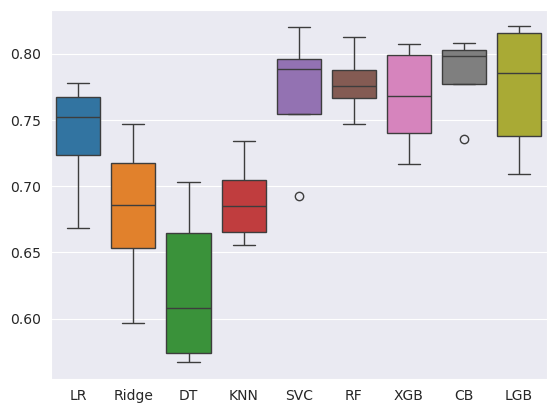

In [22]:
X_train = pd.read_csv('../data/processed/X_train_2.csv.zip', index_col=0)
y_train = pd.read_csv('../data/processed/y_train_2.csv', index_col=0)

results = {}

for name in models.keys():
    tic = time.time()
    
    FPS_OFFSET = get_fps_offset(X_train.columns)
    scaler = OffsetScaler(offset=FPS_OFFSET)
    X_train_scale = scaler.fit_transform(X_train.values)
    
    model = models[name]
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    results[name] = cross_val_score(model, X_train_scale, y_train, cv=kfold, scoring='roc_auc')
    
    toc = time.time()    
    print("%5s: %3.3f ± %3.3f    %.1fs" % (name, results[name].mean(), results[name].std(), toc - tic))
    
results = pd.DataFrame(results)
sns.boxplot(results);

/home/ergot/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ergot/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

   LR: 0.903 ± 0.011    1.0s
Ridge: 0.846 ± 0.019    0.5s
   DT: 0.797 ± 0.014    9.9s
  KNN: 0.878 ± 0.034    0.2s
  SVC: 0.912 ± 0.014    6.1s
   RF: 0.922 ± 0.024    2.1s
  XGB: 0.915 ± 0.014    14.4s
   CB: 0.925 ± 0.018    326.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  LGB: 0.916 ± 0.017    10.9s


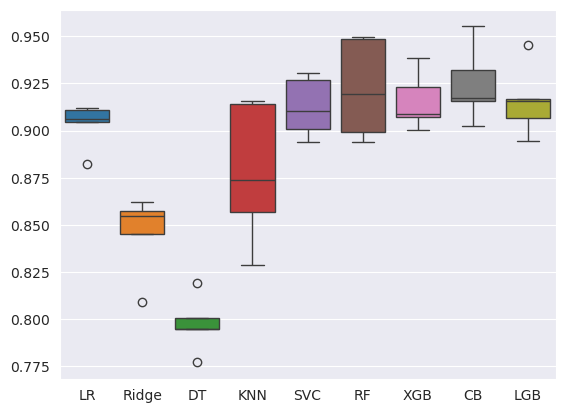

In [21]:
X_train = pd.read_csv('../data/processed/X_train_3.csv.zip', index_col=0)
y_train = pd.read_csv('../data/processed/y_train_3.csv', index_col=0)

results = {}

for name in models.keys():
    tic = time.time()
    
    FPS_OFFSET = get_fps_offset(X_train.columns)
    scaler = OffsetScaler(offset=FPS_OFFSET)
    X_train_scale = scaler.fit_transform(X_train.values)
    
    model = models[name]
    kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    results[name] = cross_val_score(model, X_train_scale, y_train, cv=kfold, scoring='roc_auc')
    
    toc = time.time()    
    print("%5s: %3.3f ± %3.3f    %.1fs" % (name, results[name].mean(), results[name].std(), toc - tic))
    
results = pd.DataFrame(results)
sns.boxplot(results);